In [10]:
import helper_functions
import numpy as np
import sklearn
#Import keras from tensorflow and not as a standalone thing (that makes things work weird idk why)
from tensorflow import keras
# CNN
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Conv1D, Activation, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import InputLayer, Dropout, LSTM, BatchNormalization, Flatten, ZeroPadding1D, AveragePooling2D, BatchNormalization, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
import pickle
#import helper_functions
from tensorflow.keras.layers import GlobalMaxPooling1D, Dropout, BatchNormalization


from sklearn.metrics import confusion_matrix

import seaborn as sns
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

In [9]:
data_path = 'data'
with open(data_path, 'rb') as f:
    data = pickle.Unpickler(f).load()

In [11]:
# Shuffle the data
dataToShuffle = []

for log, mfcc, label in zip(data['log-mel'],data['mfccs'],data['classes']):
    dataToShuffle.append([log,mfcc,label])

ShuffledData = np.array(dataToShuffle)
np.random.shuffle(ShuffledData)

In [12]:
# Separate the data into training and test datasets
Train = ShuffledData[:45305]
Test = ShuffledData[45305:]

log_train = []
mfcc_train = []
y_train = []

log_test = []
mfcc_test = []
y_test = []

for log, mfcc, label in Train:
    log_train.append(log)
    mfcc_train.append(mfcc)
    y_train.append(label)
    
for log, mfcc, label in Test:
    log_test.append(log)
    mfcc_test.append(mfcc)
    y_test.append(label)


In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

for i in range(2):
    label = y_train[45000+i]
    plt.figure()
    plt.title("Class id: "+ str(label))
    plt.imshow(x_train[45000+i])

In [56]:
log_test[0].shape


(15, 173)

In [25]:
#based on https://towardsdatascience.com/tensorflow-speech-recognition-challenge-solution-outline-9c42dbd219c9
#this one could be quite good, ^^ was getting like 80-85% accuracy (It's the 1D CNN)
#was getting barely over 60% but made the model less deep (as can be seen by comments) and it got much better ~75%->more epochs = 81%
model2 = Sequential()

model2.add(BatchNormalization())

model2.add(Conv1D(64,kernel_size=2,padding='same'))
model2.add(Activation('relu'))
model2.add(Conv1D(64,kernel_size=2,padding='same'))
model2.add(Activation('relu'))

model2.add(Dropout(0.2))

model2.add(Conv1D(128, 3,padding='same'))
model2.add(Activation('relu'))
model2.add(Conv1D(128, 3,padding='same'))
model2.add(Activation('relu'))


model2.add(Dropout(0.2))
model2.add(MaxPooling1D(2))

model2.add(GlobalMaxPooling1D())

model2.add(Dense(12, activation="softmax"))
    

In [26]:
# Import new metrics 
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()
opt = keras.optimizers.adam(lr=0.0001)

model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', precision, recall])

In [27]:
# Initiate early stopping callback (on validation set from training data 0.15)
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience = 5)

In [28]:
#Train the model #78
x_train = np.array(mfcc_train)
y_train = np.array(y_train)
history2 = model2.fit(x=x_train, y=y_train, epochs=70, batch_size=128, validation_split = 0.10, callbacks = [callback])

Epoch 1/70
319/319 [==============================] - 14s 32ms/step - loss: 1.4886 - accuracy: 0.6323 - precision_2: 0.6547 - recall_2: 0.5645 - val_loss: 1.4267 - val_accuracy: 0.6323 - val_precision_2: 0.7194 - val_recall_2: 0.4317
Epoch 2/70
319/319 [==============================] - 8s 27ms/step - loss: 1.3726 - accuracy: 0.6358 - precision_2: 0.6802 - recall_2: 0.5613 - val_loss: 1.3599 - val_accuracy: 0.6341 - val_precision_2: 0.8276 - val_recall_2: 0.3041
Epoch 3/70
319/319 [==============================] - 10s 32ms/step - loss: 1.2810 - accuracy: 0.6386 - precision_2: 0.7071 - recall_2: 0.5432 - val_loss: 1.2665 - val_accuracy: 0.6575 - val_precision_2: 0.8516 - val_recall_2: 0.3141
Epoch 4/70
319/319 [==============================] - 9s 27ms/step - loss: 1.1979 - accuracy: 0.6472 - precision_2: 0.7255 - recall_2: 0.5426 - val_loss: 1.1530 - val_accuracy: 0.6802 - val_precision_2: 0.8409 - val_recall_2: 0.3862
Epoch 5/70
319/319 [==============================] - 8s 26ms/step

In [29]:
# Save the model 2
model2.save('models\CNN2')

# Save history object
file = open('models\CNN2_history', 'wb')
pickle.dump(history2.history, file)
file.close()

INFO:tensorflow:Assets written to: models\CNN2\assets


In [34]:
# Load the model 
model2 = keras.models.load_model('models\CNN2')


# Load the history object 
file = open('models\CNN2_history', 'rb')
history2 = pickle.load(file)
file.close()

In [8]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 15, 173)           692       
_________________________________________________________________
conv1d (Conv1D)              (None, 15, 64)            22208     
_________________________________________________________________
activation (Activation)      (None, 15, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            8256      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 128)           2

In [31]:
# Testing the model 2
x_test = np.array(mfcc_test)
y_test = np.array(y_test)
score = model2.evaluate(x_test,y_test)

607/607 [==============================] - 3s 3ms/step - loss: 0.4896 - accuracy: 0.8491 - precision_2: 0.9044 - recall_2: 0.7814


In [35]:

# Model1's prediction on the test data and the desired output
output2 = model2.predict(x_test)
logits_pred2 = output2.argmax(axis=1)
logits_test2 = y_test.argmax(axis=1)

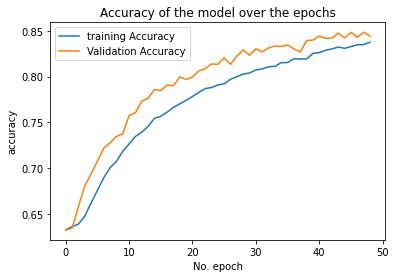

In [36]:

# Training/Validation Loss

plt.plot(history2['accuracy'], label="training Accuracy")
plt.plot(history2['val_accuracy'], label="Validation Accuracy")
plt.title('Accuracy of the model over the epochs')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

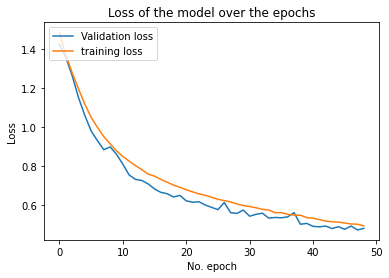

In [38]:
plt.plot(history2['val_loss'], label="Validation loss")
plt.plot(history2PermitedLabels = ['yes','no','up','down','left','right','on','off','stop','go','unknown']

cf_matrix = confusion_matrix(logits_test,logits_pred)

fig, ax = plt.subplots(figsize=(10,10))['loss'], label="training loss")
plt.title('Loss of the model over the epochs')
plt.xlabel('No. epoch')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

<AxesSubplot:>

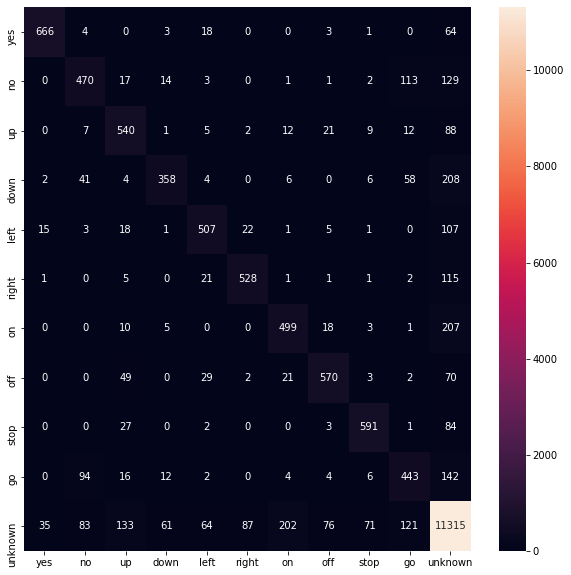

In [39]:
# Confusion matrix
PermitedLabels = ['yes','no','up','down','left','right','on','off','stop','go','unknown']

cf_matrix = confusion_matrix(logits_test2,logits_pred2)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels=PermitedLabels, yticklabels=PermitedLabels, ax = ax  )

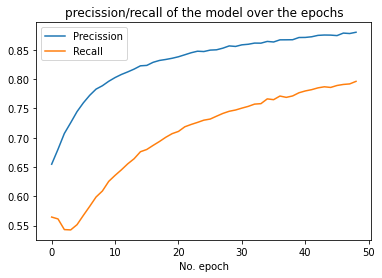

In [41]:
# Precision / Recall curve (training)
plt.plot(history2['precision_2'], label="Precission")
plt.plot(history2['recall_2'], label="Recall")
plt.title('precission/recall of the model over the epochs')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [42]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

Image(model_to_dot(model2).create(prog='dot', format='png'))

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


AttributeError: 'NoneType' object has no attribute 'create'